In [1]:
import xarray as xr
import numpy as np

import os
import torch
import math
import tqdm
import random

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
temperature_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalTemperature/Land_and_Ocean_LatLong1.nc"
co2_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalGhgEmissions/CO2_1deg_month_1850-2013.nc"

In [3]:
temperature_ds = xr.open_dataset(temperature_path)
co2_ds = xr.open_dataset(co2_path)

temperature_ds['time'] = temperature_ds['time'].assign_coords(time=np.arange(len(temperature_ds.time)))
co2_ds['Times'] = co2_ds['Times'].assign_coords(Times=np.arange(len(co2_ds.Times)))

In [4]:
# Extract temperature data
temperature_data = temperature_ds['temperature']
temperature_mean = temperature_data.mean()
temperature_std = temperature_data.std()
normalized_temperature = (temperature_data - temperature_mean) / temperature_std

climatology = temperature_ds['climatology']
land_mask = temperature_ds['land_mask']

data_dict = {
    'temperature': normalized_temperature,
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': co2_ds['value'],
    'time_length': len(co2_ds['Times'])
}

def rotate_list(lst, n):
    n = n % len(lst)  # This handles cases where n is greater than the list length
    return lst[n:] + lst[:n]


In [5]:
class RandomLocationTemperatureDataset(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 10000  # Randomly chosen number

    def __getitem__(self, index):
        while True:
            # Randomly select a location
            lat = random.choice(self.latitudes)
            lon = random.choice(self.longitudes)
            start_time = random.randint(0, self.time_steps - 1)  # Randomly select a starting time step

            temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
            co2_sequence = self.data_dict['co2'].sel(LatDim=int(89.5 - lat), LonDim=int(179.5 - lon)).values
            
            land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
            lat_norm = lat / 90

            months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
            cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
            sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

            x_temp = temperature_sequence[start_time:start_time + self.seq_length]
            x_co2 = co2_sequence[start_time:start_time + self.seq_length]
            x_combined = list(zip(x_temp, x_co2))
            
            y = temperature_sequence[start_time + self.seq_length]

            if not np.isnan(x_temp).any() and not np.isnan(y):
                # Prepare input features for each timestep
                x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
                x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
                
                return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [6]:
# Sequence length
seq_length = 12

# Create the Dataset
dataset = RandomLocationTemperatureDataset(data_dict, seq_length)

# Split data into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate over train_loader
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break  # remove this break to process all batches

8000 2000
torch.Size([16, 12, 6]) torch.Size([16])


In [7]:
# Device configuration - uses GPU if available
# Check for device availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: mps


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Initialize the LSTM model
input_size = 6  # input feature dimension
hidden_size = 100  # number of features in hidden state
num_layers = 4  # number of stacked LSTM layers
output_size = 1  # output feature dimension (predicting one value)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Parameters
num_epochs = 10
batch_size = 16

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume model initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
model.to(device)  # Ensure the model is on the correct device

for epoch in range(num_epochs):
    model.train()  # Make sure the model is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    model.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = model(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the model is back to train mode after validation
model.train()


Epoch 0: Train Loss 0.11951424181461334, Val Loss 0.8696235803961754
Epoch 1: Train Loss 1.8395106792449951, Val Loss 0.8578589435219764
Epoch 2: Train Loss 1.3878612518310547, Val Loss 0.7489119253754616
Epoch 3: Train Loss 0.4278827905654907, Val Loss 0.870862165093422
Epoch 4: Train Loss 1.032308578491211, Val Loss 0.9087816684842109
Epoch 5: Train Loss 3.548485279083252, Val Loss 0.8325528989434242
Epoch 6: Train Loss 0.45545217394828796, Val Loss 0.8576549424529075
Epoch 7: Train Loss 0.33682090044021606, Val Loss 0.8189280775785446
Epoch 8: Train Loss 2.4854719638824463, Val Loss 0.8366320301294327
Epoch 9: Train Loss 0.416359543800354, Val Loss 0.7995932068228722


LSTMModel(
  (lstm): LSTM(6, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

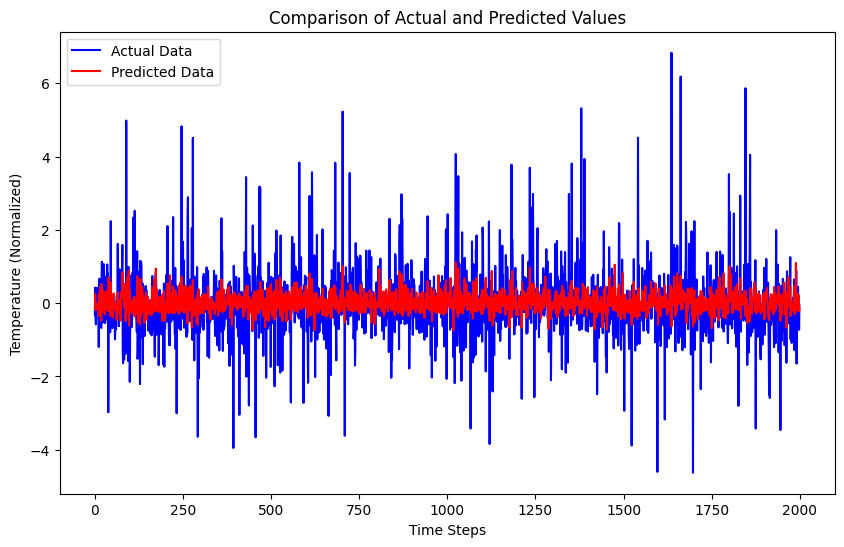

In [15]:
import matplotlib.pyplot as plt

# Assuming 'test_loader' is already defined and contains the test data
# Assuming 'model' is your trained model, loaded with trained weights and set to eval mode

model.eval()  # Ensure the model is in evaluation mode
actual = []
predicted = []

# Generate predictions and compare with actual values
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Store results
        actual.extend(labels.tolist())
        predicted.extend(outputs.squeeze().tolist())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


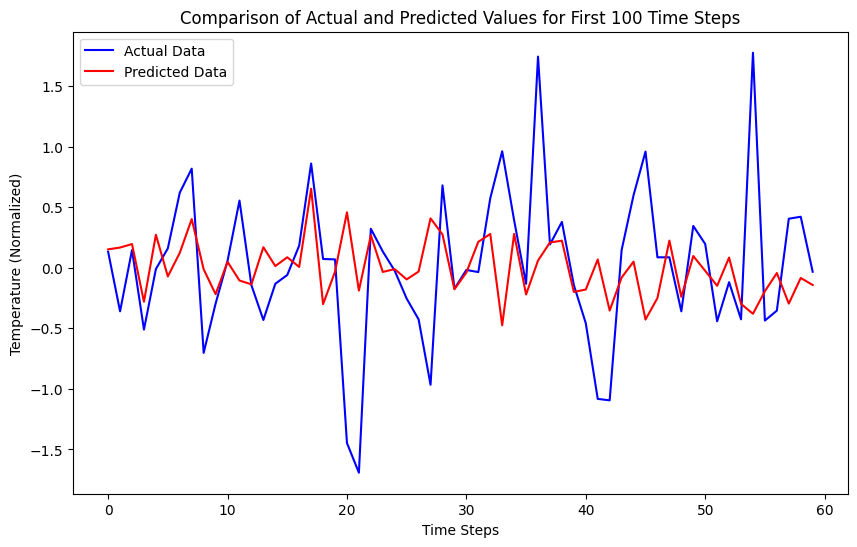

In [16]:
import matplotlib.pyplot as plt

# Assuming 'test_loader' is already defined and contains the test data
# Assuming 'model' is your trained model, loaded with trained weights and set to eval mode

model.eval()  # Ensure the model is in evaluation mode
actual = []
predicted = []

# Generate predictions and compare with actual values
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Store results
        actual.extend(labels.tolist())
        predicted.extend(outputs.squeeze().tolist())

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()
